In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all logs, 1 = filter INFO, 2 = filter WARNING, 3 = only ERROR

In [2]:
import numpy as np
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.api.layers import Dense, GlobalAveragePooling2D, Dropout, MaxPooling2D, BatchNormalization, Conv2D, Flatten
from keras.api.models import Model
from keras.api.optimizers import Adam
from PIL import ImageFile
from keras.api.applications import ResNet50


ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define new dataset path
#train_dir = r"D:\sdp\redd\train"
#test_dir = r"D:\sdp\redd\test"
train_dir = r"/workspace/sdp/redd/train"
test_dir = r"/workspace/sdp/redd/test"

E0000 00:00:1744043135.763646   10784 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744043135.768181   10784 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import numpy as np
import cv2
import random


def apply_random_degradation(image):
    """
    Applies random degradation to simulate real-world conditions.
    """
    # Randomly select which degradations to apply
    degrade_options = [
        add_gaussian_blur,
        add_motion_blur,
        add_gaussian_noise,
        add_speckle_noise,
        add_haze_effect,
        adjust_contrast_randomly,
        add_jpeg_artifacts
    ]

    # Apply 1-3 random degradations
    num_degradations = random.randint(1, 3)
    selected_degradations = random.sample(degrade_options, num_degradations)

    for degrade in selected_degradations:
        image = degrade(image)

    return image


def add_gaussian_blur(image):
    """Add random Gaussian blur"""
    if random.random() < 0.5:
        kernel_size = random.choice([3, 5, 7])
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    return image


def add_motion_blur(image):
    """Add motion blur effect"""
    if random.random() < 0.3:
        size = random.randint(5, 15)
        kernel = np.zeros((size, size))
        kernel[int((size - 1) / 2), :] = np.ones(size)
        kernel = kernel / size
        return cv2.filter2D(image, -1, kernel)
    return image


def add_gaussian_noise(image):
    """Add Gaussian noise"""
    if random.random() < 0.4:
        row, col, ch = image.shape
        mean = 0
        var = random.uniform(0.001, 0.01)
        sigma = var ** 0.5
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        gauss = gauss.reshape(row, col, ch)
        noisy = image + gauss
        return np.clip(noisy, 0, 1)
    return image


def add_speckle_noise(image):
    """Add speckle noise"""
    if random.random() < 0.3:
        row, col, ch = image.shape
        gauss = np.random.randn(row, col, ch)
        noisy = image + image * gauss * random.uniform(0.05, 0.2)
        return np.clip(noisy, 0, 1)
    return image


def add_haze_effect(image):
    """Add haze/fog effect"""
    if random.random() < 0.3:
        haze_factor = random.uniform(0.3, 0.7)
        haze_color = np.ones_like(image) * random.uniform(0.7, 0.9)
        hazy = image * haze_factor + haze_color * (1 - haze_factor)
        return np.clip(hazy, 0, 1)
    return image


def adjust_contrast_randomly(image):
    """Randomly adjust contrast"""
    if random.random() < 0.4:
        alpha = random.uniform(0.7, 1.3)
        return np.clip(alpha * image, 0, 1)
    return image


def add_jpeg_artifacts(image):
    """Simulate JPEG compression artifacts"""
    if random.random() < 0.3:
        quality = random.randint(30, 70)
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
        result, encimg = cv2.imencode('.jpg', (image * 255).astype(np.uint8), encode_param)
        decimg = cv2.imdecode(encimg, 1)
        return decimg.astype(np.float32) / 255.0
    return image

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,          # Random rotation up to 40 degrees
    width_shift_range=0.2,      # Random horizontal shift
    height_shift_range=0.2,     # Random vertical shift
    shear_range=0.2,            # Shear transformations
    zoom_range=0.2,             # Random zoom
    horizontal_flip=True,       # Random horizontal flip
    brightness_range=[0.5, 1.5],# Random brightness adjustment
    fill_mode='nearest',        # How to fill points outside boundaries
    
    # Augmentations for real-world scenarios
    channel_shift_range=50.0,   # Random channel shifts (color changes)
    
    # Custom preprocessing functions for more complex augmentations
    preprocessing_function=lambda x: apply_random_degradation(x)
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 15000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [7]:

def create_resnet_transfer_model(input_shape=(150, 150, 3), num_classes=3):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze base initially
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='swish')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='swish')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model


model = create_resnet_transfer_model()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,10

 Total params: 5,983,811 (22.83 MB)

 Trainable params: 5,980,547 (22.81 MB)

 Non-trainable params: 3,264 (12.75 KB)

In [8]:
import pickle
from keras.api.callbacks import EarlyStopping

# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=3,               # Stop after 3 epochs without improvement
    restore_best_weights=True # Restore weights from the best epoch
)

epochs = 50
history = model.fit(
    training_set,
    validation_data=test_set,
    epochs=epochs,
    callbacks=[early_stop]   
)

model.save("third_model_da.h5")
with open("history3_da.pkl", "wb") as f:
    pickle.dump(history.history, f)

print("Model and training history saved successfully!")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1744043380.324938   10906 service.cc:148] XLA service 0x7f03500259e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744043380.325325   10906 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
I0000 00:00:1744043381.069231   10906 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744043390.701201   10906 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 227s 452ms/step - accuracy: 0.3865 - loss: 3.7231 - val_accuracy: 0.4253 - val_loss: 3.3768
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 181s 387ms/step - accuracy: 0.4516 - loss: 3.3680 - val_accuracy: 0.6670 - val_loss: 2.7595
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 184s 392ms/step - accuracy: 0.4636 - loss: 3.2145 - val_accuracy: 0.6453 - val_loss: 2.6667
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 183s 390ms/step - accuracy: 0.4963 - loss: 3.0486 - val_accuracy: 0.7017 - val_loss: 2.5183
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 184s 391ms/step - accuracy: 0.4900 - loss: 2.9797 - val_accuracy: 0.7247 - val_loss: 2.4668
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 183s 391ms/step - accuracy: 0.5051 - loss: 2.8609 - val_accuracy: 0.7693 - val_loss: 2.3552
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 186s 395ms/step - accuracy: 0.5073 - loss: 2.7735 - val_accuracy: 0.7607 - val_loss: 2.3271
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 183s 390ms/step - accuracy: 0.5314 - loss: 2.67

Model and training history saved successfully!


In [ ]:
import matplotlib.pyplot as plt  # ✅ Correct
def plot_accuracy(history):
    plt.figure(figsize=(8, 5))  # Set figure size
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid()
    plt.show(block=True)  # Force displayy

plot_accuracy(history)

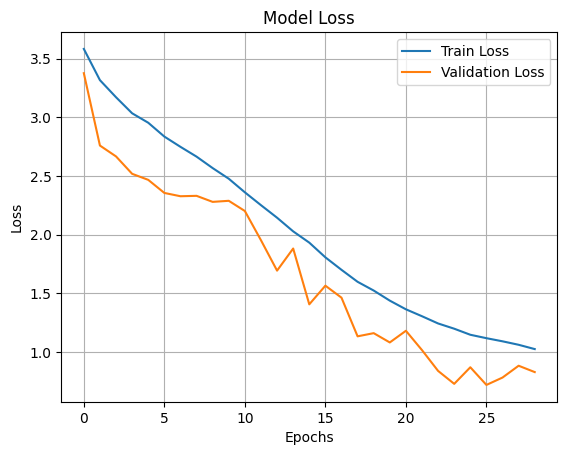

In [11]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid()
    plt.show()
plot_loss(history)

In [12]:
test_loss, test_accuracy = model.evaluate(test_set)
print(f"\n🔹 Test Accuracy after initial training: {test_accuracy * 100:.2f}%")

94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 203ms/step - accuracy: 0.7868 - loss: 0.9788

🔹 Test Accuracy after initial training: 87.63%


In [34]:
# Load and Predict a Single Image
test_image = image.load_img('/workspace/sdp/test/processed_img1.png', target_size=(150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0

result = model.predict(test_image)
class_index = np.argmax(result[0])
class_labels = {0: 'cat', 1: 'dog', 2: 'human'}
prediction = class_labels[class_index]

print(f"\n🟢 Prediction: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

🟢 Prediction: cat


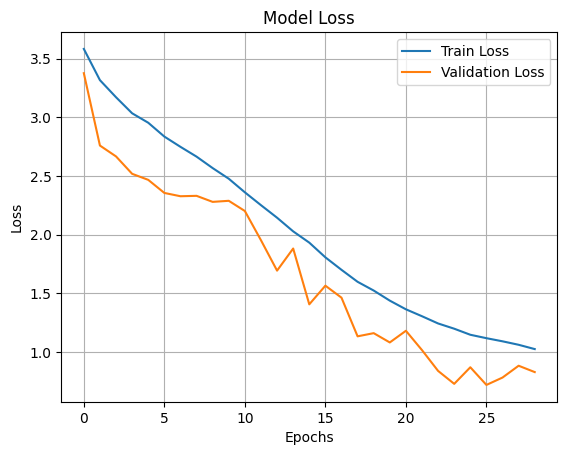